<a href="https://colab.research.google.com/github/amitpuri/openagi-codes/blob/main/notebooks/Autoencoder_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

Reloading Tuner from autoencoder_tuning/ae_tuning/tuner0.json
Results summary
Results in autoencoder_tuning/ae_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
encoding_dim: 112
Score: 0.06701883673667908

Trial 4 summary
Hyperparameters:
encoding_dim: 80
Score: 0.06992778927087784

Trial 3 summary
Hyperparameters:
encoding_dim: 64
Score: 0.07313404977321625

Trial 2 summary
Hyperparameters:
encoding_dim: 32
Score: 0.09236983209848404

Trial 0 summary
Hyperparameters:
encoding_dim: 16
Score: 0.12679189443588257


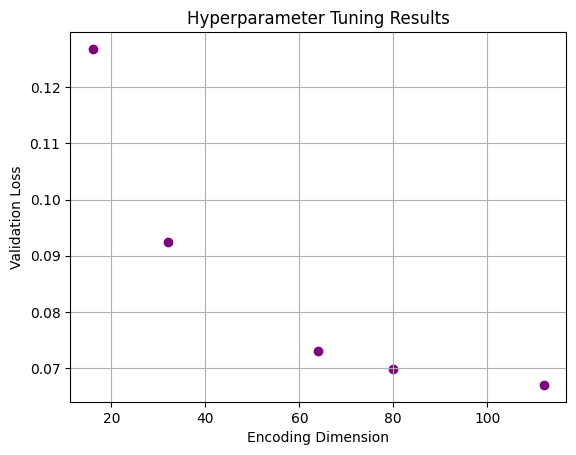

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0667 - val_loss: 0.0664
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0665 - val_loss: 0.0664
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0664 - val_loss: 0.0663
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0665 - val_loss: 0.0663
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0664 - val_loss: 0.0663
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0665 - val_loss: 0.0663
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0663 - val_loss: 0.0663
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0664 - val_loss: 0.0662
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0664 - val_loss: 0.0662
Epoch 10/10
158/235 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0665

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import keras_tuner as kt

# 1. Loading and Pre‑processing the Data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape((len(x_train), 784)).astype('float32') / 255.0
x_test = x_test.reshape((len(x_test), 784)).astype('float32') / 255.0

# 2. Define a model builder function for hyperparameter tuning
def build_autoencoder(hp):
    input_dim = 784
    # Hyperparameter: encoding dimension from 16 to 128 in steps of 16
    encoding_dim = hp.Int('encoding_dim', min_value=16, max_value=128, step=16)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# 3. Hyperparameter Tuning using Keras Tuner
tuner = kt.RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='autoencoder_tuning',
    project_name='ae_tuning'
)
tuner.search(x_train, x_train, epochs=10, validation_data=(x_test, x_test))
tuner.results_summary()

# Extract tuning results: plot encoding_dim vs. validation loss
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

encoding_dims = []
val_losses = []
for trial in trials:
    encoding_dims.append(trial.hyperparameters.get('encoding_dim'))
    val_losses.append(trial.metrics.get_last_value('val_loss'))
plt.figure()
plt.scatter(encoding_dims, val_losses, color='purple')
plt.xlabel("Encoding Dimension")
plt.ylabel("Validation Loss")
plt.title("Hyperparameter Tuning Results")
plt.grid(True)
plt.show()

# 4. Model Evaluation: Train the best model and plot loss curves
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(x_train, x_train, epochs=10, batch_size=256, validation_data=(x_test, x_test))
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()
